In [2]:
import sys
sys.path.append('..')

import cv2
from matplotlib import pyplot as plt
import os
import yaml
import numpy as np

from detection.shapes import Rectangle
from detection.litter_detection import merge_rectangles

# YOLO

In [26]:
def draw_yolo_boxes(image_path, label_path, class_names, filter_class=-1, palette=[tuple(int(c * 255) for c in color) for color in plt.cm.tab20.colors]):
    """ Draw bounding boxes in yolo format on image"""
    print("image:", image_path)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width = image.shape[:2]

    annots = []
    # Open and parse YOLO label file
    with open(label_path, "r") as f:
        for line in f:
            class_id, center_x, center_y, width, height = map(float, line.split())
            if filter_class != -1 and class_id != filter_class:
                continue

            class_id = int(class_id)

            # Convert YOLO format to pixel values
            x1 = int((center_x - (width / 2)) * image_width)
            x2 = int((center_x + (width / 2)) * image_width)
            y1 = int((center_y - (height / 2)) * image_height)
            y2 = int((center_y + (height / 2)) * image_height)
                    
            annots.append(Rectangle(x1, y1, x2, y2, class_names[class_id]))
            # Draw bounding box and label
            color = palette[class_id%20] if type(palette) is list else palette

            cv2.rectangle(image, (x1, y1), (x2,y2), color, 5)
            # cv2.putText(image, class_names[class_id], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)

    # Display the image
    plt.imshow(image)
    plt.show()

    return annots

File /home/anna/Datasets/annotated//mandrac2/beach_throwing/mandrac2/beach_throwing.yaml not found.
image: /home/anna/Datasets/annotated//mandrac2/beach_throwing/images/mandrac-beach-throwing_11_0755_25_ch4.tif


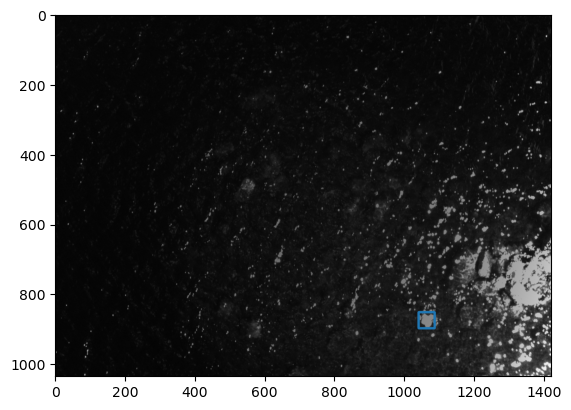

In [41]:
path = "/home/anna/Datasets/annotated/"
dataset = "mandrac2/beach_throwing"
filename = "mandrac-beach-throwing_11_0755_25_ch4"

try:
    with open(f"{path}/{dataset}/{dataset}.yaml", "r") as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print(f"File {path}/{dataset}/{dataset}.yaml not found.")
    config = {"names": [""]}


annots = draw_yolo_boxes(f"{path}/{dataset}/images/{filename}.tif", 
                f"{path}/{dataset}/labels/{filename}.txt",
                config["names"])

In [ ]:
piles = merge_rectangles(annots, 15)

image = cv2.imread(f"{path}/{dataset}/images/train/{filename}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for pile in piles:
    pile.draw(image)

plt.imshow(image)
plt.show()

In [ ]:
# From saved YOLO model
from ultralytics import YOLO
model = YOLO("pool-form1_pool-3-channels_random_best.pt")
ds_path = "/home/anna/Datasets/created/pool-form1_pool-3-channels_random/"

results = model.predict(os.path.join(ds_path, "images", "val", "bags_12_0001_6_E_G_E # G.png"))
boxes = [Rectangle(*box[:4]) for box in results[0].boxes.xyxy]

In [ ]:
image = cv2.imread(os.path.join(ds_path, "images", "val", "bags_12_0001_6_E_G_E # G.png"))
for box in boxes:
    box.draw(image)

plt.imshow(image)

# COCO

8


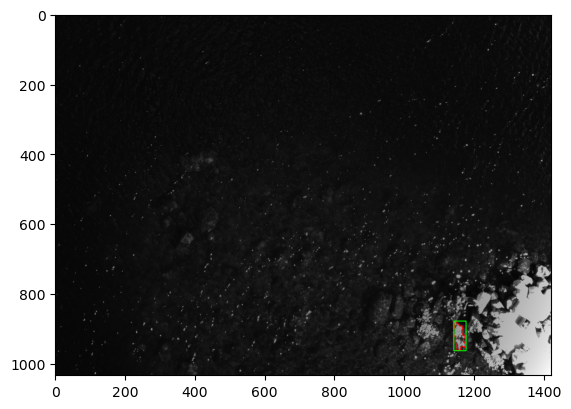

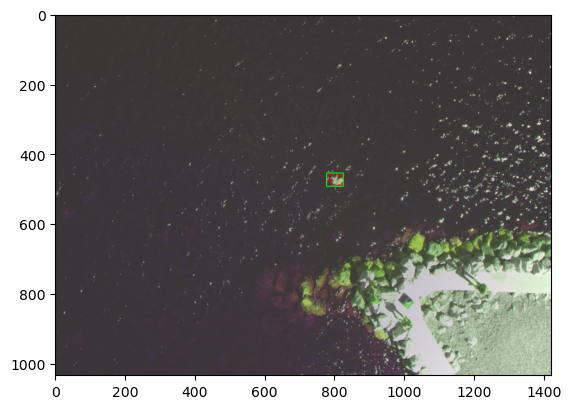

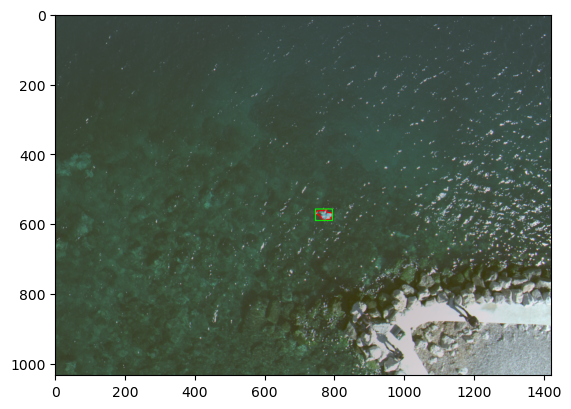

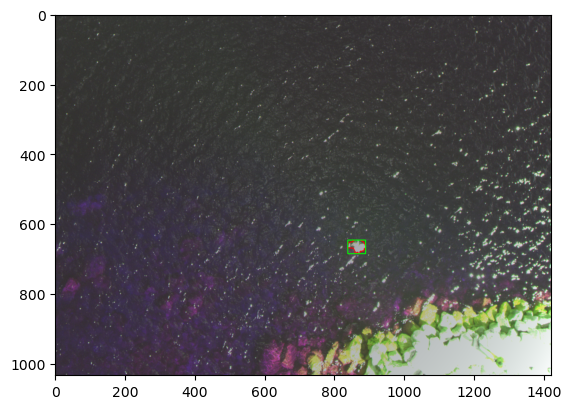

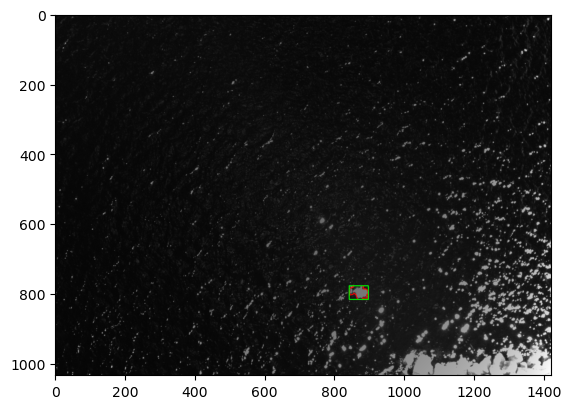

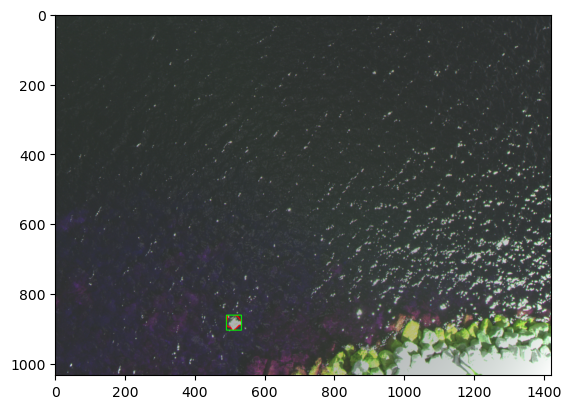

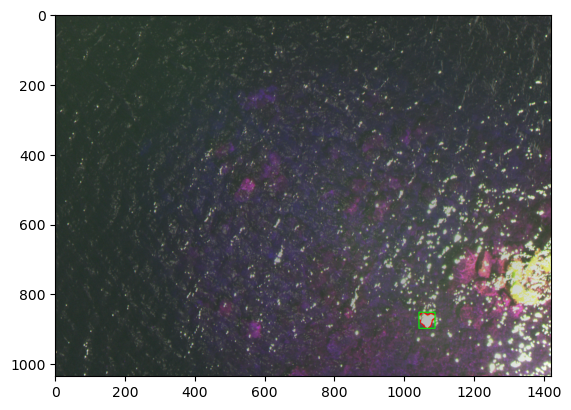

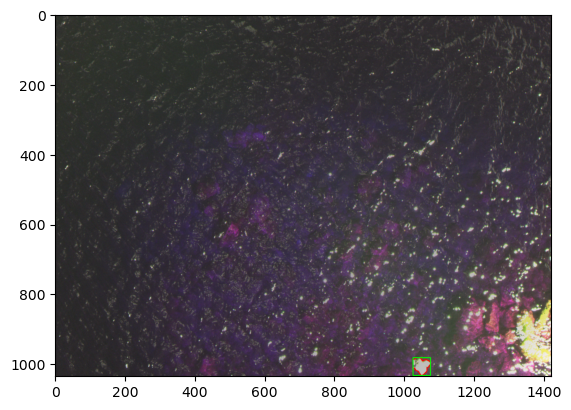

In [39]:
import json
import cv2
import matplotlib.pyplot as plt

ds_path = "/home/anna/Datasets/annotated/"
experiment_name = "beach_throwing"

# Load COCO JSON
with open(f"{ds_path}/mandrac_{experiment_name}_annots.json") as f:
    coco_data = json.load(f)

# plot coco annotations
from collections import defaultdict

# get annots for each image
image_anns = defaultdict(list)
for ann in coco_data["annotations"]:
    image_anns[ann["image_id"]].append(ann)

print(len(image_anns))

for img, anns in image_anns.items():
    # load image
    fn = coco_data["images"][img-1]["file_name"]

    ds_for_annot_path = f"/home/anna/Datasets/for_annotation/mandrac_2025/{experiment_name}"
    alt = fn.split("_")[1] 
    nr = fn.split("_")[0]

    image = cv2.imread(f"{ds_for_annot_path}/{alt}/{nr}_{alt}/{fn.replace('tiff', 'tif')}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # draw annotations
    for ann in anns:
        polygon = np.array(ann["segmentation"]).reshape((-1, 2)).astype(int)
        cv2.polylines(image, [polygon], isClosed=True, color=(255, 0, 0), thickness=2)
        bbox = ann["bbox"]  # [x,y,w,h]
        cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3])), (0, 255, 0), 2)

    plt.imshow(image)
    plt.show()

In [40]:
# Convert to yolo and copy to new directory

ds_path = "/home/anna/Datasets/annotated"
experiment_name = "beach_throwing"
experiment_time = "11"

# Load COCO JSON
with open(f"{ds_path}/mandrac_{experiment_name}_annots.json") as f:
    coco_data = json.load(f)

# Create class_id to name mapping (adjust based on your data)
class_map = {1: "pile"}  # Update with your actual classes

# Process annotations
image_anns = defaultdict(list)
for ann in coco_data["annotations"]:
    image_anns[ann["image_id"]].append(ann)

print(f"Found {len(image_anns)} annotated images")

for img_id, anns in image_anns.items():
    # Get image info
    img_info = coco_data["images"][img_id-1]  # Assuming sequential IDs starting at 1
    fn = img_info["file_name"]
    img_width, img_height = img_info["width"], img_info["height"]
    
    # Load image
    ds_for_annot_path = f"/home/anna/Datasets/for_annotation/mandrac_2025/{experiment_name}"
    alt = fn.split("_")[1]
    nr = fn.split("_")[0]
    # img_path = f"{ds_path}/mandrac2/{experiment_name}/images/{experiment_name}_{experiment_time}_{fn}"

    img_path = f"{ds_for_annot_path}/{alt}/{nr}_{alt}/{fn.replace('tiff', 'tif')}" # in new directory there are only channel images, no RGB or other
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Prepare YOLO output file
    yolo_txt_base_path = f"{ds_path}/mandrac2/{experiment_name}/labels"
    yolo_txt_paths = [f"{yolo_txt_base_path}/mandrac-{experiment_name.replace('_', '-')}_{experiment_time}_{'_'.join(fn.split('_')[:-1])}_ch{i}.txt" for i in range(0, 5)]

    for ann in anns:
        # Convert COCO bbox [x,y,w,h] to YOLO format [x_center, y_center, w, h] (normalized)
        x, y, w, h = ann["bbox"]
        x_center = (x + w/2) / img_width
        y_center = (y + h/2) / img_height
        w_norm = w / img_width
        h_norm = h / img_height
            
    for path in yolo_txt_paths:            
        with open(path, 'w') as yolo_file:
            # Write to YOLO file (class_id defaults to 0 if not specified)
            class_id = ann.get("category_id", 0) - 1  # YOLO uses 0-based indices
            yolo_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

print("YOLO conversion complete!")

Found 8 annotated images
YOLO conversion complete!


# Moving files

In [ ]:
# move from for annotation to annotated
# find . -mindepth 3 -maxdepth 3 -type f -regex '.*ch[0-9]\.tif' -exec cp {} /home/anna/Datasets/annotated/mandrac2/marina/images \;

# rename (remeber to cd to the new directory)
# for file in *; do mv "$file" "mandrac-marina_12_$file"; done
